# **Análise de sentimentos de comentários do Spotify**

**Descrição do projeto**

Extrair e analizar os tópicos mais relevantes dos comentários negativos do Spotify, identificando, se possível, falhas relevantes do app de música.


**Técnicas utilizadas**

- Análise de sentimentos
- Modelagem de tópicos

# **BIBLIOTECAS UTILIZADAS**

In [ ]:
# Bibliotecas para data frame e graficos
import pandas as pd 
from IPython.display import display, HTML
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteca para preprocessamento
import re
import nltk
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize , download , pos_tag

# Biblioteca para analise de sentimento
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Biblioteca para nuvem de palavras
from wordcloud import WordCloud, STOPWORDS

# Biblioteca para modelagem de topicos
from gensim import corpora
import pickle
import gensim
import pyLDAvis.gensim

# **DOWNLOADS E INSTALLS**

In [ ]:
# Downloads
download(['punkt','averaged_perceptron_tagger','stopwords','wordnet'])
nltk.download('omw-1.4')

# Install
!pip install pyLDAvis==2.1.2

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Conhecendo o data set**

In [ ]:
# Os dados foram retirados de: https://www.kaggle.com/datasets/mfaaris/spotify-app-reviews-2022
df = pd.read_csv("reviews.csv")
display(df)

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN
...,...,...,...,...,...
61589,2022-01-01 03:01:29,Even though it was communicated that lyrics fe...,1,6,NaN
61590,2022-01-01 02:13:40,"Use to be sooo good back when I had it, and wh...",1,0,NaN
61591,2022-01-01 01:02:29,This app would be good if not for it taking ov...,2,10,NaN
61592,2022-01-01 00:49:23,The app is good hard to navigate and won't jus...,2,1,NaN


Para este projeto usaremos apenas as colunas "Review" e "Rating"

Portanto podemos jogar fora todas as outras colunas:

In [ ]:
df = pd.read_csv("reviews.csv", usecols=["Review", "Rating"])
display(df)

,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
2,"This pop-up ""Get the best Spotify experience o...",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1
...,...,...
61589,Even though it was communicated that lyrics fe...,1
61590,"Use to be sooo good back when I had it, and wh...",1
61591,This app would be good if not for it taking ov...,2
61592,The app is good hard to navigate and won't jus...,2


# **Limpeza dos dados**

In [ ]:
# Aqui vamos criar uma nova coluna chamada "clean_doc" onde terá a coluna review apos a limpeza

# Remover numeros e pontuacao
df['clean_doc'] = df['Review'].str.replace("[^a-zA-Z-']", " ", regex=True)

# Remover urls e tags
df["clean_doc"]= df["clean_doc"].apply(lambda x: re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , str(x)))

# Deixando tudo minusculas
df["clean_doc"]=df["clean_doc"].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Remover espacos extras
df["clean_doc"]=df["clean_doc"].apply(lambda x: " ".join(x.split()))

E finalmente:

In [ ]:
display(df)

,Review,Rating,clean_doc
0,"Great music service, the audio is high quality...",5,great music service the audio is high quality ...
1,Please ignore previous negative rating. This a...,5,please ignore previous negative rating this ap...
2,"This pop-up ""Get the best Spotify experience o...",4,this pop-up get the best spotify experience on...
3,Really buggy and terrible to use as of recently,1,really buggy and terrible to use as of recently
4,Dear Spotify why do I get songs that I didn't ...,1,dear spotify why do i get songs that i didn't ...
...,...,...,...
61589,Even though it was communicated that lyrics fe...,1,even though it was communicated that lyrics fe...
61590,"Use to be sooo good back when I had it, and wh...",1,use to be sooo good back when i had it and whe...
61591,This app would be good if not for it taking ov...,2,this app would be good if not for it taking ov...
61592,The app is good hard to navigate and won't jus...,2,the app is good hard to navigate and won't jus...


# **Criando a coluna com os Tokens**

In [ ]:
stopwords = stopwords.words('english')

# usaremos a tecnica de lemmatizacao
wnl = WordNetLemmatizer()

tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True)

def tokenizer_review(review, tokenizer=tokenizer,stopwords=stopwords):
    tokens = tokenizer.tokenize(review) 
    tokens = [word for word in tokens if word not in stopwords]
    tokens = [word for word in tokens if word not in string.punctuation]
    tokens = [wnl.lemmatize(word) for word in tokens] 

    return tokens

Agora temos uma nova coluna com os tokens:

In [ ]:
df['tokens'] = df['clean_doc'].apply(lambda x: tokenizer_review(x))
display(df)

,Review,Rating,clean_doc,tokens
0,"Great music service, the audio is high quality...",5,great music service the audio is high quality ...,"[great, music, service, audio, high, quality, ..."
1,Please ignore previous negative rating. This a...,5,please ignore previous negative rating this ap...,"[please, ignore, previous, negative, rating, a..."
2,"This pop-up ""Get the best Spotify experience o...",4,this pop-up get the best spotify experience on...,"[pop-up, get, best, spotify, experience, andro..."
3,Really buggy and terrible to use as of recently,1,really buggy and terrible to use as of recently,"[really, buggy, terrible, use, recently]"
4,Dear Spotify why do I get songs that I didn't ...,1,dear spotify why do i get songs that i didn't ...,"[dear, spotify, get, song, put, playlist, shuf..."
...,...,...,...,...
61589,Even though it was communicated that lyrics fe...,1,even though it was communicated that lyrics fe...,"[even, though, communicated, lyric, feature, a..."
61590,"Use to be sooo good back when I had it, and wh...",1,use to be sooo good back when i had it and whe...,"[use, sooo, good, back, downloaded, free, vers..."
61591,This app would be good if not for it taking ov...,2,this app would be good if not for it taking ov...,"[app, would, good, taking, device, start, comp..."
61592,The app is good hard to navigate and won't jus...,2,the app is good hard to navigate and won't jus...,"[app, good, hard, navigate, let, play, song, c..."


# **Reajustando os valores da coluna Rating**

Usaremos o seguinte critério para reajustar os valores da coluna Rating: 

[1, 2] => -1 (Negativo)

[3]    => 0  (Neutro)

[4, 5] => 1  (Positivo)

Dessa forma, ficamos com o seguinto conjunto de dados:

In [ ]:
df["Rating"].replace(1, value= -1, inplace=True)
df["Rating"].replace(2, value= -1, inplace=True)
df["Rating"].replace(3, value= 0, inplace=True)
df["Rating"].replace(4, value= 1, inplace=True)
df["Rating"].replace(5, value= 1, inplace=True)

display(df)

,Review,Rating,clean_doc,tokens
0,"Great music service, the audio is high quality...",1,great music service the audio is high quality ...,"[great, music, service, audio, high, quality, ..."
1,Please ignore previous negative rating. This a...,1,please ignore previous negative rating this ap...,"[please, ignore, previous, negative, rating, a..."
2,"This pop-up ""Get the best Spotify experience o...",1,this pop-up get the best spotify experience on...,"[pop-up, get, best, spotify, experience, andro..."
3,Really buggy and terrible to use as of recently,-1,really buggy and terrible to use as of recently,"[really, buggy, terrible, use, recently]"
4,Dear Spotify why do I get songs that I didn't ...,-1,dear spotify why do i get songs that i didn't ...,"[dear, spotify, get, song, put, playlist, shuf..."
...,...,...,...,...
61589,Even though it was communicated that lyrics fe...,-1,even though it was communicated that lyrics fe...,"[even, though, communicated, lyric, feature, a..."
61590,"Use to be sooo good back when I had it, and wh...",-1,use to be sooo good back when i had it and whe...,"[use, sooo, good, back, downloaded, free, vers..."
61591,This app would be good if not for it taking ov...,-1,this app would be good if not for it taking ov...,"[app, would, good, taking, device, start, comp..."
61592,The app is good hard to navigate and won't jus...,-1,the app is good hard to navigate and won't jus...,"[app, good, hard, navigate, let, play, song, c..."


# **Análise de sentimentos**

Nesta etapa usaremos a biblioteca TextBlob para fazer a analise de sentimentos

In [ ]:
# Algoritmo para extrair o sentimento de um documento
def sentiment(review):
  score = TextBlob(review).sentiment

  if score[0] > 0:
    return 1
  if score[0] < 0:
    return -1
  return 0

In [ ]:
# Aplicando o algortimo para todos os documentos
df['sentiment'] = df['clean_doc'].apply(lambda x: sentiment(x))
display(df)

,Review,Rating,clean_doc,tokens,sentiment
0,"Great music service, the audio is high quality...",1,great music service the audio is high quality ...,"[great, music, service, audio, high, quality, ...",1
1,Please ignore previous negative rating. This a...,1,please ignore previous negative rating this ap...,"[please, ignore, previous, negative, rating, a...",1
2,"This pop-up ""Get the best Spotify experience o...",1,this pop-up get the best spotify experience on...,"[pop-up, get, best, spotify, experience, andro...",1
3,Really buggy and terrible to use as of recently,-1,really buggy and terrible to use as of recently,"[really, buggy, terrible, use, recently]",-1
4,Dear Spotify why do I get songs that I didn't ...,-1,dear spotify why do i get songs that i didn't ...,"[dear, spotify, get, song, put, playlist, shuf...",0
...,...,...,...,...,...
61589,Even though it was communicated that lyrics fe...,-1,even though it was communicated that lyrics fe...,"[even, though, communicated, lyric, feature, a...",1
61590,"Use to be sooo good back when I had it, and wh...",-1,use to be sooo good back when i had it and whe...,"[use, sooo, good, back, downloaded, free, vers...",1
61591,This app would be good if not for it taking ov...,-1,this app would be good if not for it taking ov...,"[app, would, good, taking, device, start, comp...",-1
61592,The app is good hard to navigate and won't jus...,-1,the app is good hard to navigate and won't jus...,"[app, good, hard, navigate, let, play, song, c...",1


# **Rating x Sentiment**

Podemos fazer uma comparação entre a coluna rating (modificada através do critério pré-definido) e a coluna sentiment adquirida através da biblioteca TextBlob

**Rating**

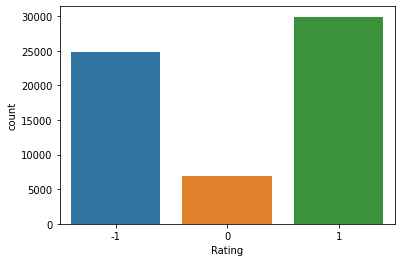

In [ ]:
sns.countplot(x = df['Rating']);

**Sentiment**

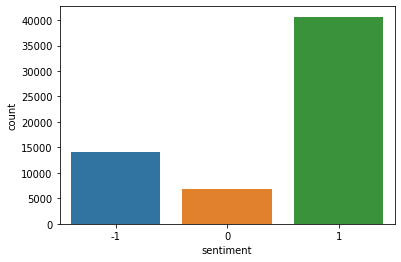

In [ ]:
sns.countplot(x = df['sentiment']);

Como podemos ver,  os positivos ainda são maioria e os neutros minoria, porém quantitativamente o número de negativos e positivos mudou bastante enquanto que os neutros permaneceram muito próximos.

# **Nuvem de Palavras**

Iremos agora criar uma nova coluna onde será armazenado a concatenação dos tokens apenas dos reviews considerados negativos pela análise de sentimentos do TextBlob

In [ ]:
reviews_negativos = pd.DataFrame(df.loc[df['sentiment'] == -1 ] )
reviews_negativos['tokens_joined'] = reviews_negativos['tokens'].apply(lambda x : " ".join(x) )

Ficando dessa forma:

In [ ]:
display(reviews_negativos["tokens_joined"])

3                       really buggy terrible use recently
7        still extremely slow changing storage external...
13       worst app always say i'm offline never showed ...
16       android user load glitch app player bar disapp...
17       can't listen downloaded playlist i'm offline w...
                               ...                        
61577    giving free service ad ad bad frustrating want...
61586    one day able switch song fast forward go back ...
61587    favourite app feel sorry artist lost lot reven...
61588    back one frkng star first there's spotify tryi...
61591    app would good taking device start comp there'...
Name: tokens_joined, Length: 14192, dtype: object

Agora iremos fazer a nuvem de palavras para podermos ver as palavras mais relevantes

In [ ]:
def show_wordcloud(data, title = 'Nuvem de palavras - Comentários Negativos'):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=40,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

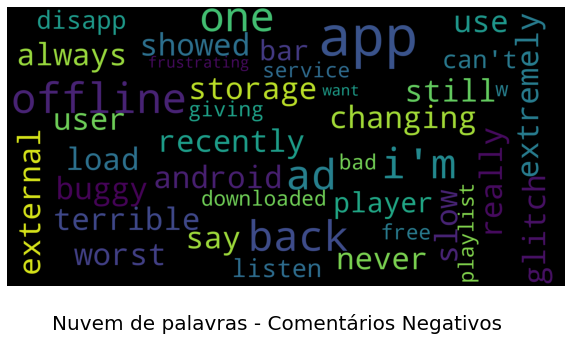

In [ ]:
show_wordcloud(reviews_negativos['tokens_joined'])

Podemos ver que palavras como buggy, terrible, worst e bad aparecem bastante e são palavras que demonstram muita insatisfação com o produto

# **Modelagem de Tópicos usando o algoritmo LDA**

Através do algoritmo LDA iremos extrair os tópicos mais relevantes dos comentários negativos.

In [ ]:
gensim_dictionary = corpora.Dictionary(reviews_negativos['tokens'])
gensim_corpus = [gensim_dictionary.doc2bow(token, allow_update=True) for token in reviews_negativos['tokens']]

pickle.dump(gensim_corpus, open('gensim_corpus_corpus.pkl', 'wb'))
gensim_dictionary.save('gensim_dictionary.gensim')

lda_model = gensim.models.ldamodel.LdaModel(gensim_corpus, num_topics=3, id2word=gensim_dictionary, passes=20)
lda_model.save('gensim_model.gensim')

topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

lda_visualization = pyLDAvis.gensim.prepare(lda_model, gensim_corpus, gensim_dictionary, sort_topics=False)

A saída de streaming foi truncada nas últimas 5000 linhas.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np

(0, '0.044*"app" + 0.021*"playing" + 0.017*"music" + 0.017*"stop" + 0.014*"update" + 0.013*"spotify" + 0.013*"phone" + 0.013*"play" + 0.012*"time" + 0.011*"fix"')
(1, '0.094*"song" + 0.036*"play" + 0.034*"playlist" + 0.023*"listen" + 0.021*"want" + 0.021*"app" + 0.016*"music" + 0.016*"can\'t" + 0.015*"like" + 0.014*"ad"')
(2, '0.024*"spotify" + 0.024*"app" + 0.019*"premium" + 0.019*"ad" + 0.013*"music" + 0.009*"account" + 0.008*"service" + 0.008*"use" + 0.007*"even" + 0.007*"time"')


/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  head(R).drop('saliency', 1)


Portanto teremos o seguinte conjunto dos três tópicos mais relevantes:

In [ ]:
pyLDAvis.display(lda_visualization)

# **CONCLUSÃO**

Por fim, podemos verificar que os usuários têm tido problemas com anúncios mesmo tendo o produto premium, que não deveria conter anúncios, outro ponto que pode ser destacado são alguns bugs com podcasts e pause de músicas.